In [1]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# для расчетов над tdb
from pycalphad import Database, equilibrium, variables as v 

# для MCMC расчетов
import pymc as pm  # пакет для MCMC расчетов 
import arviz as az # пакет для работы с типом данных arviz
import pytensor
import pytensor.tensor as pt
import theano
theano.config.exception_verbosity = 'high' # должно выдавать подробное описание ошибки, но не помогает

import aesara


# пути к tdb
cc10_path = "tdbs/CoCr-01Oik_with_new_functions.tdb"

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\emgebrishvili\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Pytho

Running on PyMC v5.1.2


In [2]:
# __version__

Функция для преобразования данных

In [3]:
def from_xarray_to_pandas(xarray_data, phase_str):
    cr_tuple = xarray_data.X.sel(component = 'CR').data[0][0]
    phase_tuple = xarray_data.Phase.data[0][0]
    t_tuple = xarray_data.T.data
    
    df_res = pd.DataFrame()
    df_res['T'] = ''
    df_res['phase'] = ''
    df_res['cr_conc'] = ''
    
    df = pd.DataFrame()
    df['T'] = t_tuple
    df['phase_1'] = ''
    df['phase_2'] = ''
    df['phase_3'] = ''
    df['cr_conc_1'] = ''
    df['cr_conc_2'] = ''
    df['cr_conc_3'] = ''
    
    # print(t_tuple, len(t_tuple))
    for i in range(len(t_tuple)):
        df.iloc[i, df.columns.get_loc('phase_1')] = phase_tuple[i][0][0]
        df.iloc[i, df.columns.get_loc('phase_2')] = phase_tuple[i][0][1]
        df.iloc[i, df.columns.get_loc('phase_3')] = phase_tuple[i][0][2]
        df.iloc[i, df.columns.get_loc('cr_conc_1')] = cr_tuple[i][0][0]
        df.iloc[i, df.columns.get_loc('cr_conc_2')] = cr_tuple[i][0][1]
        df.iloc[i, df.columns.get_loc('cr_conc_3')] = cr_tuple[i][0][2]
    
    df_1 = df[(df['phase_1'] == phase_str)]
    df_1 = df_1[['phase_1', 'cr_conc_1', 'T']]
    df_1.rename(columns = {'phase_1':'phase', 'cr_conc_1':'cr_conc'}, inplace = True)
    
    df_2 = df[(df['phase_2'] == phase_str)]
    df_2 = df_2[['phase_2', 'cr_conc_2', 'T']]
    df_2.rename(columns = {'phase_2':'phase', 'cr_conc_2':'cr_conc'}, inplace = True)
    
    df_res = pd.concat([df_1, df_2])
    
    return df_res

Подгружаем tdb

In [4]:
db10 = Database(cc10_path)

Задаем глобальные переменные = концентрационные диапазоны для расчетов над tdb = условия для получения расчетных данных

In [5]:
phases10 = list(db10.phases.keys())
press = 101325
elements = ['CR', 'CO', 'VA']
el_cnt = 1

In [6]:
phases10

['LIQUID', 'FCC_A1', 'BCC_A2', 'HCP_A3', 'SIGMA_OLD']

Подгружаем опытные данные

In [7]:
df_sigma_fcc = pd.read_excel('emp_data/sigma_fcc_allibert.xls')
# df_sigma_bcc = pd.read_excel('emp_data/sigma_bcc_allibert.xls')
# df_sigma_hcp = pd.read_excel('emp_data/sigma_hcp_allibert.xls')

df_sigma_fcc['T'] = df_sigma_fcc['T'].round(2)
df_sigma_fcc['cr_conc'] = df_sigma_fcc['cr_conc'].round(6)
df_sigma_fcc_sigma_old = df_sigma_fcc[(df_sigma_fcc['phase'] == 'sigma_old')].reset_index()
df_sigma_fcc_sigma_old

,index,cr_conc,T,phase
0,6,0.532019,1321.35,sigma_old
1,7,0.542469,1226.97,sigma_old
2,8,0.547749,1471.91,sigma_old
3,9,0.554050,1370.79,sigma_old
4,10,0.556156,1269.66,sigma_old
5,11,0.559283,1422.47,sigma_old


Класс, который позволяет интегрировать данные, полученные с помощью pymc, в наши функции \
п.с. название не имеет связи с тем, что происходит в коде, они все остались из тьюториала: https://www.pymc.io/projects/examples/en/latest/case_studies/blackbox_external_likelihood_numpy.html

В этом классе нужно расчитать правдоподобие нашей модели.

Чтобы расчитать правдоподобие нам понадобится:
1. рассчитать эквилиюриум
2. рассчитать правдоподобие

Т.о. 

на вход мы подаем следующие данные:
1. conditions
2. parameters
3. y_obs
4. phases, elements

а на выход: 
1. likelihood

In [8]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):
#     определяем тип входящих и исходящих данных
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, db, conditions, phase, elemets, y_obs):
        self.db_tdb = db
        self.conditions_dict = conditions
        self.phase_str = phase
        self.elements_list = elements
        self.y_obs_nparray = y_obs

    def perform(self, node, inputs, outputs):
        
        (theta,) = inputs  # this will contain my variables
        
        COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1 = theta
        
        new_parameters = {
         'SIGMA_OLD_COCRCO_0' : COCRCO_0
         ,'SIGMA_OLD_COCRCO_1': COCRCO_1
         ,'SIGMA_OLD_COCRCR_0': COCRCR_0
         ,'SIGMA_OLD_COCRCR_1': COCRCR_1
        }
        
        y_eq = from_xarray_to_pandas(equilibrium(self.db_tdb
                                            , self.elements_list
                                            , self.phase_str
                                            , self.conditions_dict
                                            , parameters = new_parameters
                                        ), self.phase_str)['cr_conc'].astype(float) # cr_conc - нужно абстрагировать
               
        outputs[0][0] = np.sum((self.y_obs_nparray - y_eq)**2)
                             

Определеяем модель в терминах pymc

In [9]:
df_sigma_fcc_sigma_old = df_sigma_fcc_sigma_old.sort_values('T')

T = df_sigma_fcc_sigma_old['T'].to_numpy()
phase = 'SIGMA_OLD'
press = 101325
elements = ['CR', 'CO', 'VA']
el_cnt = 1

y_obs = df_sigma_fcc_sigma_old['cr_conc'].values
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: T, v.N: el_cnt}

In [10]:
logl = LogLike(db10, conditions, phase, elements, y_obs)

**Комментарий:**

1. Все же алгоритм не позволяет использовать NUTS, он по умолчанию выбирает Slice
2. При использовании ``pm.DensityDist()`` возникает проблема:\
*TypeError: Since ``v4.0.0`` the ``observed`` parameter should be of type ``pd.Series``, ``np.array``, or ``pm.Data``. Previous versions allowed passing distribution parameters as a dictionary in ``observed``, in the current version these parameters are positional arguments.* \
В таком случае, я не понимаю смысл его применения.

In [11]:
test_model = pm.Model()

with test_model:
    # uniform priors on m and c
    COCRCO_0 = pm.Normal("SIGMA_OLD_COCRCO_0", mu=-103863.0, sigma=1)
    COCRCO_1 = pm.Normal("SIGMA_OLD_COCRCO_1", mu=47.47, sigma=1)
    COCRCR_0 = pm.Normal("SIGMA_OLD_COCRCR_0", mu=-248108.8, sigma=1)
    COCRCR_1 = pm.Normal("SIGMA_OLD_COCRCR_1", mu=79.12, sigma=1) 
    
    # theta = [COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1]
    theta = pt.as_tensor_variable([COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1])
    
    # likelihood = pm.DensityDist("likelihood", logl(theta), observed=theta)
    likelihood = pm.Potential("likelihood", logl(theta))
    
    trace = pm.sample(draws=100, tune=90) #, step = pm.Metropolis()

Only 100 samples in chain.
C:\Users\emgebrishvili\AppData\Local\Programs\Python\Python310\lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [SIGMA_O

Sampling 4 chains for 90 tune and 100 draw iterations (360 + 400 draws total) took 285 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'SIGMA_OLD_COCRCO_0'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCO_0'}>],
       [<Axes: title={'center': 'SIGMA_OLD_COCRCO_1'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCO_1'}>],
       [<Axes: title={'center': 'SIGMA_OLD_COCRCR_0'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCR_0'}>],
       [<Axes: title={'center': 'SIGMA_OLD_COCRCR_1'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCR_1'}>]], dtype=object)

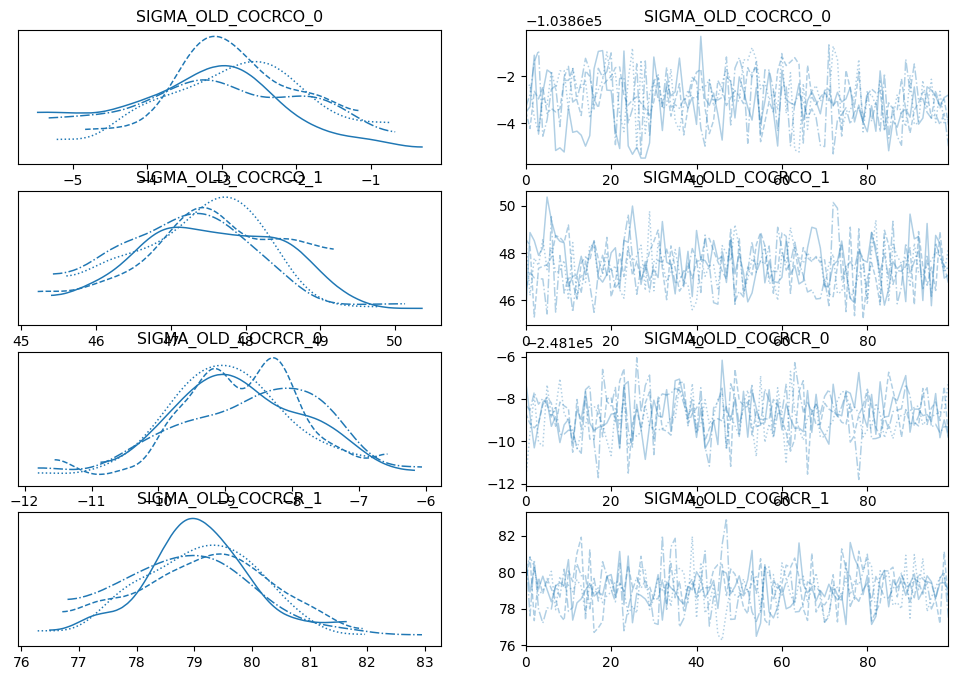

In [12]:
# plot the traces
az.plot_trace(trace)

**Какое то очень низкое правдоподобие...**

In [23]:
likelihood.eval()

0.014698172247999953